# MILESTONE 2

## i. Introduction

Name : Jovanca Stevani Tanjung

Batch 002 HCK

---

Objectives:
- be able to understand NLP concept
- be able to prepare data to be used in NLP model.
- be able to implement Artificial Neural Network with the data given.
- be able to analyze and explain the layers made.

## ii. Import Libraries

In [106]:
# Import Libraries

import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping


from sklearn.feature_extraction.text import CountVectorizer #Menghitung frekuensi kata yang muncul di suatu data
from sklearn.model_selection import train_test_split #Fungsi utk membagi dataset menjadi data training dan test
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## iii. Data Loading

In [2]:
#Data Loading
train = pd.read_csv('train.csv', encoding='latin1')
test = pd.read_csv('test.csv', encoding = 'latin1')

The dataset I got from kaggle splitted into 2 dataset, which are train dataset dan test dataset. I will concat these 2 dataset to make it easier to preprocess. But before taking action on concat, I will check whether the columns are the same.

In [3]:
train.columns

Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)'],
      dtype='object')

In [4]:
test.columns

Index(['textID', 'text', 'sentiment', 'Time of Tweet', 'Age of User',
       'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'],
      dtype='object')

seems like there is difference between train data and test data. which shown by the existence of 'selected_text' in train data which test data doesn't have. so I am going to drop 'selected_text' column from train data.

In [5]:
train.drop('selected_text', axis=1, inplace=True)

### Data Cleaning

In [6]:
train.isnull().sum()

textID              0
text                1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [7]:
test.isnull().sum()

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64

after checking the missing value, it is seen that there is missing value in train data and there are missing values from test data which I'll drop it from both dataset.

In [8]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [112]:
df = pd.concat([train, test], axis=0, ignore_index=True)
df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


for better convenience, I concatenate both train data and test data so it would be easier to do data preprocessing.

In [10]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stpwds = list(set(stopwords.words('english')))

before doing further data cleaning using NLP, first thing is to define the method. like the stemmer, lemmatizer and stopwords that is going to be used in the analysis.

In [11]:
#Create functions to be implemented for DataFrame

def text_proses(teks):
  teks = teks.lower()
  teks = re.sub("@[A-Za-z0-9_]+"," ", teks) #Removing mention
  teks = re.sub("#[A-Za-z0-9_]+"," ", teks) #Removing hashtag
  teks = re.sub(r"\\n"," ",teks) #Removing \n
  teks = teks.strip()
  teks = re.sub(r"http\S+", " ", teks) #Removing link
  teks = re.sub(r"www.\S+", " ", teks) #Removing link
  teks = re.sub("[^A-Za-z\s']"," ", teks) #Remove non-words
  teks = re.sub("rt"," ",teks) #Removing RT
  tokens = word_tokenize(teks)
  teks = stemmer.stem(teks)
  teks = lemmatizer.lemmatize(teks)
  teks = re.sub(r"can\'t", "can not", teks)
  teks = re.sub(r"n\'t", " not", teks)
  teks = re.sub(r"\'re", " are", teks)
  teks = re.sub(r"\'s", " is", teks)
  teks = re.sub(r"\'d", " would", teks)
  teks = re.sub(r"\'ll", " will", teks)
  teks = re.sub(r"\'t", " not", teks)
  teks = re.sub(r"\'ve", " have", teks)
  teks = re.sub(r"\'m", " am", teks)
  teks = ' '.join([word for word in tokens if word not in stpwds])
  emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return teks
  return emoji_pattern.sub(r'', teks)

in this step, I do the data cleaning on the data by doing case folding such as:
- Converting the data text to lowercase
- Removing numbers from the data text
- Removing punctuation from the data text
- Removing whitespaces

and some other action also done, like handling the emojis, symbols, removing hashtag, mention, non words and link from the text in the dataset.

In [113]:
df['text_processed'] = df['text'].apply(lambda x: text_proses(x))
df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),text_processed
0,cb774db0d1,"I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,noon,21-30,Albania,2877797.0,27400.0,105.0,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,boss bullying
3,9642c003ef,what interview! leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0,sons put releases already bought


after cleaning, the cleaned data is storaged in `text_processed` column.

In [13]:
df_cleaned = df[['text', 'text_processed', 'sentiment']]
df_cleaned.head()

,text,text_processed,sentiment
0,"I`d have responded, if I were going",responded going,neutral
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego,negative
2,my boss is bullying me...,boss bullying,negative
3,what interview! leave me alone,interview leave alone,negative
4,"Sons of ****, why couldn`t they put them on t...",sons put releases already bought,negative


to make it easier, i only took 3 columns for further analysis which are `text`, `text_processed` and `sentiment` columns.

In [14]:
df_cleaned['sentiment_score'] = df_cleaned['sentiment'].replace({'negative' : 0, 'neutral' : 1, 'positive' : 2})
df_cleaned.head()


,text,text_processed,sentiment,sentiment_score
0,"I`d have responded, if I were going",responded going,neutral,1
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego,negative,0
2,my boss is bullying me...,boss bullying,negative,0
3,what interview! leave me alone,interview leave alone,negative,0
4,"Sons of ****, why couldn`t they put them on t...",sons put releases already bought,negative,0


changing/encode the sentiment is also important to make it easier to analyze, which is going to defined the sentiment using number to identified each categories. `0 for negative sentiment`, `1 for neutral sentiment` and `2 for positive sentiment`.

In [16]:
df_cleaned.drop('sentiment', axis=1, inplace=True)

,text,text_processed,sentiment_score
0,"I`d have responded, if I were going",responded going,1
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego,0
2,my boss is bullying me...,boss bullying,0
3,what interview! leave me alone,interview leave alone,0
4,"Sons of ****, why couldn`t they put them on t...",sons put releases already bought,0
...,...,...,...
31009,"its at 3 am, im very tired but i can`t sleep ...",im tired sleep try,0
31010,All alone in this old house again. Thanks for...,alone old house thanks net keeps alive kicking...,2
31011,I know what you mean. My little dog is sinkin...,know mean little dog sinking depression wants ...,0
31012,_sutra what is your next youtube video gonna b...,sutra next youtube video gon na love videos,2


### Data Splitting

In [17]:
data = df_cleaned.copy()

In [18]:
x = data.drop('sentiment_score', axis=1)
y = data['sentiment_score']

In [19]:
#Split train, test and val set from the dataset
x_train_full, x_test,  y_train_full, y_test = train_test_split(x,
                                                               y,
                                                               shuffle=True, test_size=0.2,
                                                               stratify= y
                                                               )

x_train, x_val, y_train, y_val = train_test_split(x_train_full,
                                                  y_train_full,
                                                  shuffle=True, test_size=0.2)

I splitted the data into 3 set of data which are train-set data, test-set data and validation data.

In [20]:
#Checking the shape of each set data
for i in [x_train, x_test, x_val, y_train, y_test, y_val ]:
    print(i.shape)

(19848, 3)
(6203, 3)
(4963, 3)
(19848,)
(6203,)
(4963,)


In [21]:
x_train.head()

,text,text_processed,sentiment
13693,what was it? I missed it.,missed,neutral
29146,Yea! Headed home to change and head over to P...,yea headed home change head pelham sad thought...,negative
24772,took the most amazing power nap ever. now its ...,took amazing power nap ever starbucks time,positive
22116,another fun night!! chilled wit my homie @ gr...,another fun night chilled wit homie green tu l...,positive
757,LMAO...Ha! No I just simply wanted to go to NY!,lmao ha simply wanted go ny,positive


## iv. Exploratory Data Analysis (EDA)

### Total Number of Each Sentiment



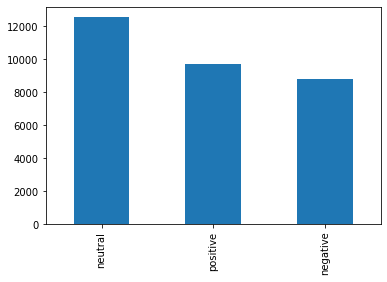

In [23]:
df['sentiment'].value_counts().plot(kind='bar')

from the visualization above, it can be seen that the target data is imbalance. where the neutral sentiment is being the most frequent sentiment that appeared with around 12000 values, meanwhile other sentiments are less than 10000 in total.

### WordCloud

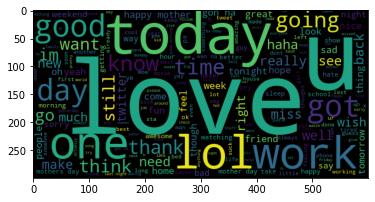

In [24]:
wc = WordCloud(width=600,height=300).generate(' '.join(df.text_processed))
plt.imshow(wc);

Based on the wordcloud above, we can tell that the most frequent words that appeared from the data is 'love', 'today', 'work', 'u', 'one', etc.

### Top 5 Countries with the Most Frequent Negative Sentiment

In [25]:
negative = df[df['sentiment'] == 'negative']

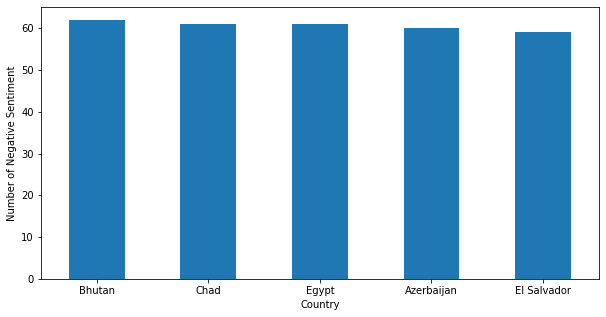

In [26]:
plt.figure(figsize=(10,5))
negative['Country'].value_counts().head(5).sort_values(ascending=False).plot.bar()
plt.xticks(rotation=0)
plt.xlabel("Country")
plt.ylabel("Number of Negative Sentiment")
plt.show()

Based on the plot above, we can see that top 5 countries that has the most frequent negative sentiment are 'Bhutan', 'Chad', 'Egypt', 'Azerbaijan', 'El Salvador'. so it means these 5 countries has the highest contribution on writing stuff that is sentimentally negative.

### Top 5 Countries with the Most Frequent Neutral Sentiment

In [27]:
neutral = df[df['sentiment'] == 'neutral']

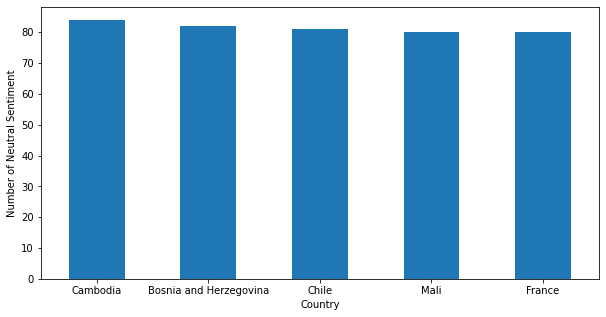

In [28]:
plt.figure(figsize=(10,5))
neutral['Country'].value_counts().head(5).sort_values(ascending=False).plot.bar()
plt.xticks(rotation=0)
plt.xlabel("Country")
plt.ylabel("Number of Neutral Sentiment")
plt.show()

Based on the plot above, it can be seen that these 5 countries have the highest contribution on writing tweet that is sentimentally neutral. these are 'Cambodia', 'Bosnia and Herzegovina', 'Chile', 'Mali', and 'France'

### Top 5 Countries with the Most Frequent Positive Sentiment

In [29]:
positive = df[df['sentiment'] == 'positive']

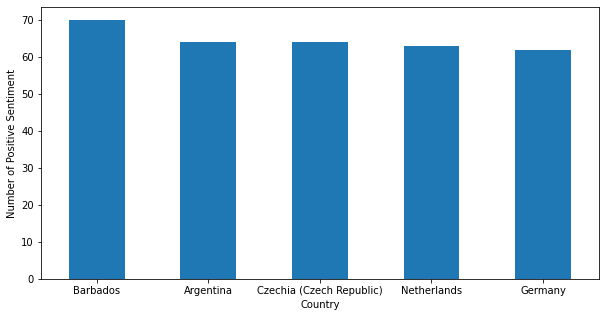

In [30]:
plt.figure(figsize=(10,5))
positive['Country'].value_counts().head(5).sort_values(ascending=False).plot.bar()
plt.xticks(rotation=0)
plt.xlabel("Country")
plt.ylabel("Number of Positive Sentiment")
plt.show()

Based on the plot above, it can be seen that these countries are the top 5 countries that has the most frequent writing stuff that is sentimentally positive. which is a really good thing, these countries are 'Barbados', 'Argentina', 'Czechia', 'Netherlands', and 'Germany'.

### Total Number of Age of User Range

In [31]:
age = df.groupby('Age of User')

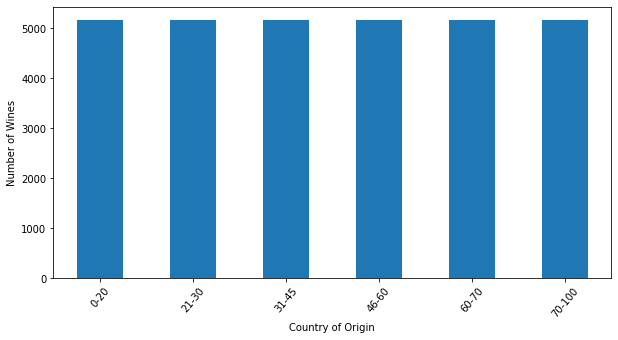

In [32]:
plt.figure(figsize=(10,5))
age.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Country of Origin")
plt.ylabel("Number of Wines")
plt.show()

Based on the plot above, it can be seen that there is no difference from each age that is contributing the writing which means these age has equally distribution.

## v. Data Preprocessing

In [33]:
# Get Vocabularies

Vectorize = CountVectorizer()
x_train_vec = Vectorize.fit_transform(x_train['text_processed'])
x_val_vec = Vectorize.transform(x_val['text_processed'])
x_test_vec = Vectorize.transform(x_test['text_processed'])

x_train_vec

<19848x19026 sparse matrix of type '<class 'numpy.int64'>'
	with 133471 stored elements in Compressed Sparse Row format>

In [34]:
# Checking the total number of vocab and token length in one document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in x_train['text_processed']])

print("total vocab unique:", total_vocab)
print("Maximum length of the sentences is:", max_sen_len, "words")

total vocab unique: 19026
Maximum length of the sentences is: 23 words


after checking the total number of vocab from the data and also the maximum length of the sentence, it can be seen that there is 19026 total vocab from the data after cleaning. and the maximum length of the sentence is 23 words.

### Vectorization and Embedding

In [35]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=19000,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(x_train['text_processed'])

after done cleaning the data, then doing vectorization using some parameters which you can see from the syntax above.

In [36]:
# Embedding

embedding = Embedding(input_dim=19000,
                      output_dim=128,
                      embeddings_initializer="GlorotUniform",
                      input_length=max_sen_len
                      )

and after done vectorization, the next step is embedding the data. and I use 'GlorotUniform' as the initializer.

In [37]:
## Document Example
print('Contoh Document')
print(x_train.text_processed[21199])
print('')

## Text Vectorization Result
print('Hasil Text Vectorization')
print(text_vectorization([x_train.text_processed[21199]]))
print('Ukuran vector : ', text_vectorization([x_train.text_processed[21199]]).shape)
print('')

## Embedding Result
print('Hasil Embedding')
print(embedding(text_vectorization([x_train.text_processed[21199]])))
print('Ukuran vector : ', embedding(text_vectorization([x_train.text_processed[21199]])).shape)

Contoh Document
evil credit card companies god sta ing build credit get stupid ding

Hasil Text Vectorization
tf.Tensor(
[[1303 1178  558 4048  182   65  255 2883 1178    4  262 7368    0    0
     0    0    0    0    0    0    0    0    0]], shape=(1, 23), dtype=int64)
Ukuran vector :  (1, 23)

Hasil Embedding
tf.Tensor(
[[[ 0.00069603 -0.00228478 -0.00704354 ...  0.00204196 -0.01418464
   -0.0122687 ]
  [ 0.00181726 -0.00097541 -0.00512591 ... -0.00493485 -0.01531406
    0.0025286 ]
  [ 0.01464832  0.01622773  0.00826421 ...  0.00208168  0.01270873
    0.00182289]
  ...
  [-0.01444685  0.01757886 -0.0033533  ...  0.00147162 -0.0171659
   -0.00632804]
  [-0.01444685  0.01757886 -0.0033533  ...  0.00147162 -0.0171659
   -0.00632804]
  [-0.01444685  0.01757886 -0.0033533  ...  0.00147162 -0.0171659
   -0.00632804]]], shape=(1, 23, 128), dtype=float32)
Ukuran vector :  (1, 23, 128)


## vi. Model Definition


### Change the Target to One Hot Encoding

In [38]:
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

before defining the model, we need to encode the target first which is the sentiment_score.

In [39]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train['text_processed'], y_train_ohe))

# ## Shuffle and slice train dataset.
# train_dataset = train_dataset.shuffle(buffer_size=7043).batch(32)

# val_dataset = tf.data.Dataset.from_tensor_slices((x_val['text_processed'], y_val_ohe))
# val_dataset = val_dataset.batch(32)

# ## Now we get a test dataset.
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test['text_processed'], y_test_ohe))
# test_dataset = test_dataset.batch(32)

In [40]:
#Global Average Pooling Base Model

model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(GlobalAveragePooling1D())
model.add(Dense(16,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer= "Adamax",metrics='accuracy')


In [41]:
#LSTM Base Model

model2 = Sequential()
model2.add(text_vectorization)
model2.add(embedding)
model2.add(LSTM(32, return_sequences=True))
model2.add(LSTM(32))
model2.add(Dense(3,activation='softmax'))

model2.compile(loss='categorical_crossentropy',optimizer='Adamax' ,metrics='accuracy')


In [42]:
#GRU Base Model

model3 = Sequential()
model3.add(text_vectorization)
model3.add(embedding)
model3.add(GRU(32, return_sequences=True))
model3.add(GRU(32))
model3.add(Dense(3,activation='softmax'))

model3.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics='accuracy')


## vii. Model Training

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

### Global Average Pooling Base Model

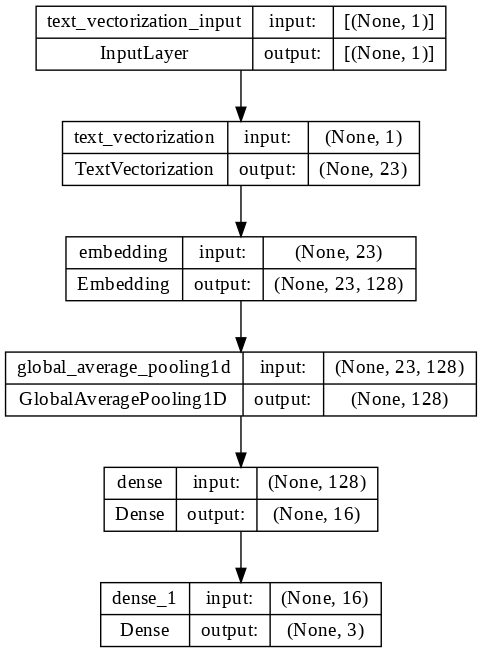

In [44]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

In [45]:
#Training Global Average Pooling Base Model

model1 = model.fit(x_train['text_processed'],
                         y_train_ohe,
                         epochs=50,
                         validation_data=(x_test['text_processed'], y_test_ohe),
                          callbacks=[es])

Epoch 1/50
621/621 [==============================] - 4s 5ms/step - loss: 1.0669 - accuracy: 0.4176 - val_loss: 1.0276 - val_accuracy: 0.4562
Epoch 2/50
621/621 [==============================] - 3s 5ms/step - loss: 0.9412 - accuracy: 0.5532 - val_loss: 0.8832 - val_accuracy: 0.5944
Epoch 3/50
621/621 [==============================] - 3s 5ms/step - loss: 0.8228 - accuracy: 0.6406 - val_loss: 0.8187 - val_accuracy: 0.6399
Epoch 4/50
621/621 [==============================] - 3s 4ms/step - loss: 0.7653 - accuracy: 0.6729 - val_loss: 0.7857 - val_accuracy: 0.6600
Epoch 5/50
621/621 [==============================] - 3s 4ms/step - loss: 0.7288 - accuracy: 0.6962 - val_loss: 0.7750 - val_accuracy: 0.6681
Epoch 6/50
621/621 [==============================] - 3s 5ms/step - loss: 0.7022 - accuracy: 0.7090 - val_loss: 0.7580 - val_accuracy: 0.6795
Epoch 7/50
621/621 [==============================] - 3s 4ms/step - loss: 0.6788 - accuracy: 0.7210 - val_loss: 0.7586 - val_accuracy: 0.6866
Epoch 

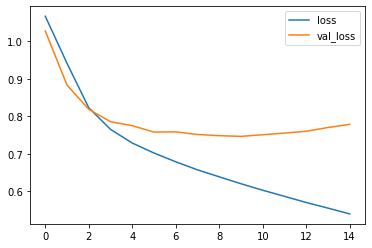

In [46]:
metrics = pd.DataFrame(model1.history)
metrics[['loss', 'val_loss']].plot()

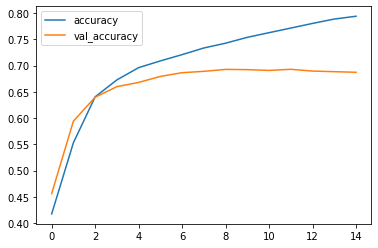

In [47]:
metrics = pd.DataFrame(model1.history)
metrics[['accuracy', 'val_accuracy']].plot()

### LSTM Base Model

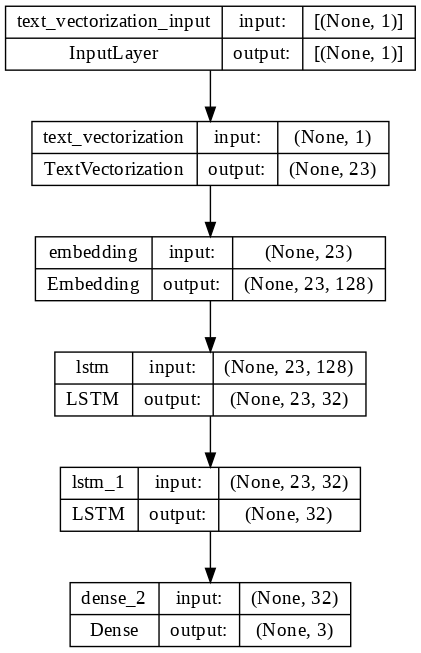

In [118]:
plot_model(model2,'model2.png',show_shapes=True,dpi=100)

In [48]:
#Training LSTM Base Model

model_lstm = model2.fit(x_train['text_processed'],
                         y_train_ohe,
                         epochs=30,
                         validation_data=(x_test['text_processed'], y_test_ohe))

Epoch 1/30
621/621 [==============================] - 10s 10ms/step - loss: 0.5928 - accuracy: 0.7597 - val_loss: 0.7995 - val_accuracy: 0.6777
Epoch 2/30
621/621 [==============================] - 5s 8ms/step - loss: 0.4999 - accuracy: 0.8116 - val_loss: 0.7922 - val_accuracy: 0.6747
Epoch 3/30
621/621 [==============================] - 6s 9ms/step - loss: 0.4757 - accuracy: 0.8234 - val_loss: 0.8094 - val_accuracy: 0.6876
Epoch 4/30
621/621 [==============================] - 5s 8ms/step - loss: 0.4576 - accuracy: 0.8336 - val_loss: 0.8081 - val_accuracy: 0.6871
Epoch 5/30
621/621 [==============================] - 5s 8ms/step - loss: 0.4385 - accuracy: 0.8416 - val_loss: 0.8245 - val_accuracy: 0.6885
Epoch 6/30
621/621 [==============================] - 6s 9ms/step - loss: 0.4166 - accuracy: 0.8528 - val_loss: 0.8436 - val_accuracy: 0.6860
Epoch 7/30
621/621 [==============================] - 5s 8ms/step - loss: 0.3941 - accuracy: 0.8632 - val_loss: 0.8736 - val_accuracy: 0.6619
Epoc

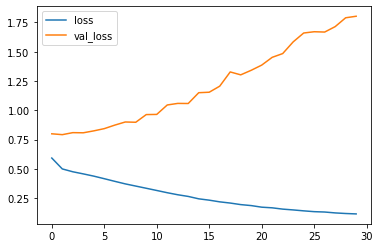

In [49]:
metrics = pd.DataFrame(model_lstm.history)
metrics[['loss', 'val_loss']].plot()

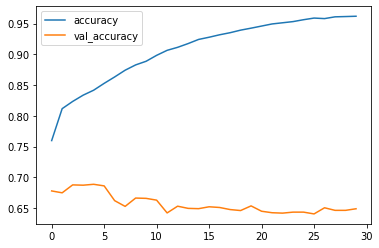

In [50]:
metrics = pd.DataFrame(model_lstm.history)
metrics[['accuracy', 'val_accuracy']].plot()

### GRU Base Model

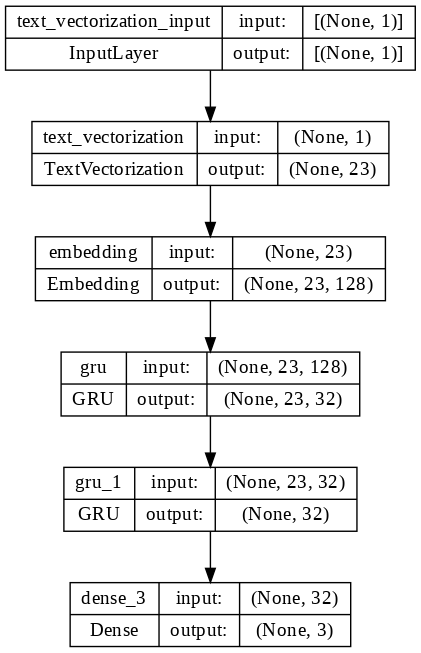

In [119]:
plot_model(model3,'model3.png',show_shapes=True,dpi=100)

In [51]:
#Training GRU Base Model

model_gru = model3.fit(x_train['text_processed'],
                         y_train_ohe,
                         epochs=30,
                         validation_data=(x_test['text_processed'], y_test_ohe))

Epoch 1/30
621/621 [==============================] - 9s 10ms/step - loss: 0.8314 - accuracy: 0.5940 - val_loss: 0.8031 - val_accuracy: 0.6903
Epoch 2/30
621/621 [==============================] - 5s 9ms/step - loss: 0.4595 - accuracy: 0.8329 - val_loss: 0.8328 - val_accuracy: 0.6842
Epoch 3/30
621/621 [==============================] - 5s 8ms/step - loss: 0.3949 - accuracy: 0.8598 - val_loss: 0.8975 - val_accuracy: 0.6729
Epoch 4/30
621/621 [==============================] - 5s 8ms/step - loss: 0.3287 - accuracy: 0.8901 - val_loss: 0.9721 - val_accuracy: 0.6697
Epoch 5/30
621/621 [==============================] - 5s 8ms/step - loss: 0.2692 - accuracy: 0.9157 - val_loss: 1.1249 - val_accuracy: 0.6297
Epoch 6/30
621/621 [==============================] - 5s 8ms/step - loss: 0.2245 - accuracy: 0.9337 - val_loss: 1.1528 - val_accuracy: 0.6331
Epoch 7/30
621/621 [==============================] - 5s 8ms/step - loss: 0.2000 - accuracy: 0.9439 - val_loss: 1.2120 - val_accuracy: 0.6357
Epoch

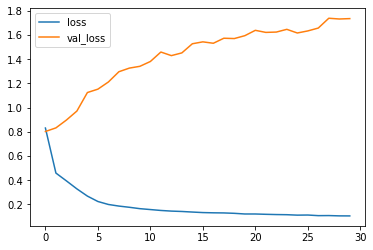

In [52]:
metrics = pd.DataFrame(model_gru.history)
metrics[['loss', 'val_loss']].plot()

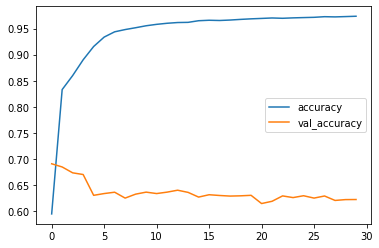

In [53]:
metrics = pd.DataFrame(model_gru.history)
metrics[['accuracy', 'val_accuracy']].plot()

## Model Improvement

### Gloval Average Pooling Tuning Model

In [54]:
#Model Tuning for Global Average Pooling Model

model_tn = Sequential()
model_tn.add(text_vectorization)
model_tn.add(embedding)
model_tn.add(GlobalAveragePooling1D())
model_tn.add(Dense(32,activation='relu'))
model_tn.add(tf.keras.layers.BatchNormalization())
model_tn.add(Dense(32,activation='relu'))
model_tn.add(tf.keras.layers.Dropout(0.1))
model_tn.add(Dense(3,activation='softmax'))


opt = keras.optimizers.Adagrad(learning_rate=0.0001)
model_tn.compile(loss='categorical_crossentropy',optimizer= opt ,metrics='accuracy')


In [55]:
#Training Global Average Pooling Tuning Model

model_tun = model_tn.fit(x_train['text_processed'],
                         y_train_ohe,
                         epochs=30,
                         validation_data=(x_test['text_processed'], y_test_ohe))

Epoch 1/30
621/621 [==============================] - 4s 5ms/step - loss: 1.1200 - accuracy: 0.3411 - val_loss: 1.0946 - val_accuracy: 0.3672
Epoch 2/30
621/621 [==============================] - 3s 5ms/step - loss: 1.0855 - accuracy: 0.3892 - val_loss: 1.0783 - val_accuracy: 0.3921
Epoch 3/30
621/621 [==============================] - 3s 5ms/step - loss: 1.0682 - accuracy: 0.4126 - val_loss: 1.0650 - val_accuracy: 0.4130
Epoch 4/30
621/621 [==============================] - 3s 5ms/step - loss: 1.0519 - accuracy: 0.4430 - val_loss: 1.0535 - val_accuracy: 0.4309
Epoch 5/30
621/621 [==============================] - 3s 5ms/step - loss: 1.0381 - accuracy: 0.4773 - val_loss: 1.0431 - val_accuracy: 0.4496
Epoch 6/30
621/621 [==============================] - 3s 5ms/step - loss: 1.0260 - accuracy: 0.5028 - val_loss: 1.0346 - val_accuracy: 0.4657
Epoch 7/30
621/621 [==============================] - 3s 5ms/step - loss: 1.0160 - accuracy: 0.5269 - val_loss: 1.0267 - val_accuracy: 0.4825
Epoch 

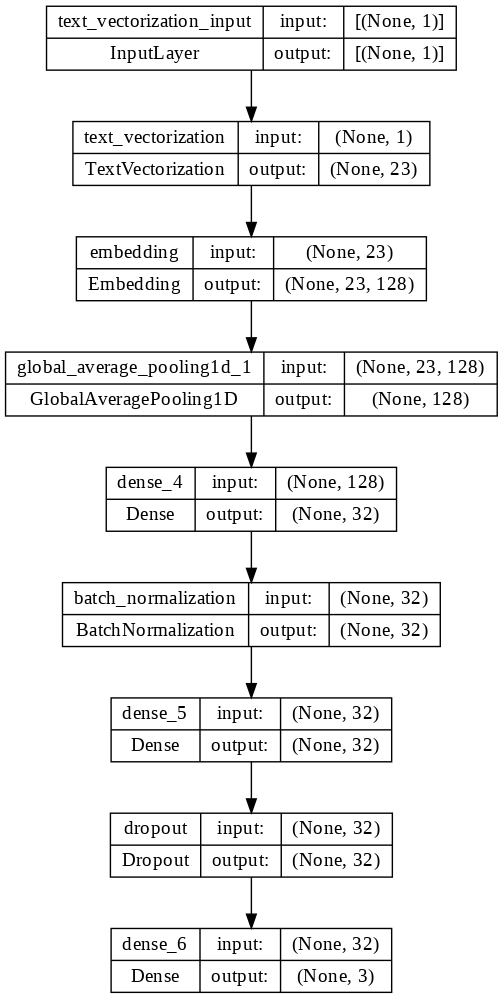

In [121]:
plot_model(model_tn,'model_tn.png',show_shapes=True,dpi=100)

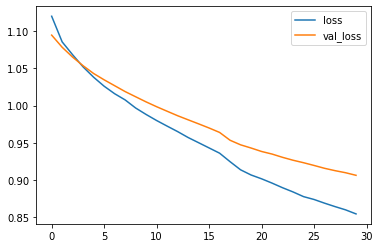

In [56]:
metrics = pd.DataFrame(model_tun.history)
metrics[['loss', 'val_loss']].plot()

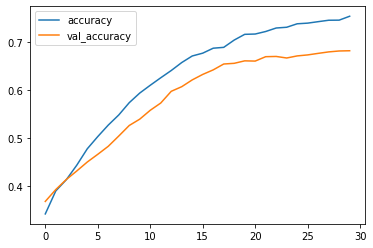

In [57]:
metrics = pd.DataFrame(model_tun.history)
metrics[['accuracy', 'val_accuracy']].plot()

### LSTM Tuning Model

In [58]:
#Model Tuning for LSTM Model

model2_tn = Sequential()
model2_tn.add(text_vectorization)
model2_tn.add(embedding)
model2_tn.add(LSTM(64, return_sequences=True))
model2_tn.add(tf.keras.layers.BatchNormalization())
model2_tn.add(LSTM(64))
model2_tn.add(tf.keras.layers.Dropout(0.1))
model2_tn.add(Dense(3,activation='softmax'))

opt = keras.optimizers.Adagrad(learning_rate=0.0001)
model2_tn.compile(loss='categorical_crossentropy',optimizer=opt ,metrics='accuracy')


In [59]:
#Training LSTM Tuning Model

model2_tun = model2_tn.fit(x_train['text_processed'],
                         y_train_ohe,
                         epochs=30,
                         validation_data=(x_test['text_processed'], y_test_ohe))

Epoch 1/30
621/621 [==============================] - 10s 11ms/step - loss: 1.0974 - accuracy: 0.3788 - val_loss: 1.0878 - val_accuracy: 0.4006
Epoch 2/30
621/621 [==============================] - 6s 10ms/step - loss: 1.0775 - accuracy: 0.4135 - val_loss: 1.0724 - val_accuracy: 0.4077
Epoch 3/30
621/621 [==============================] - 6s 10ms/step - loss: 1.0620 - accuracy: 0.4316 - val_loss: 1.0602 - val_accuracy: 0.4200
Epoch 4/30
621/621 [==============================] - 6s 10ms/step - loss: 1.0441 - accuracy: 0.4624 - val_loss: 1.0456 - val_accuracy: 0.4474
Epoch 5/30
621/621 [==============================] - 5s 9ms/step - loss: 1.0235 - accuracy: 0.4980 - val_loss: 1.0270 - val_accuracy: 0.4885
Epoch 6/30
621/621 [==============================] - 6s 10ms/step - loss: 0.9962 - accuracy: 0.5462 - val_loss: 1.0037 - val_accuracy: 0.5299
Epoch 7/30
621/621 [==============================] - 6s 9ms/step - loss: 0.9637 - accuracy: 0.5932 - val_loss: 0.9748 - val_accuracy: 0.5825


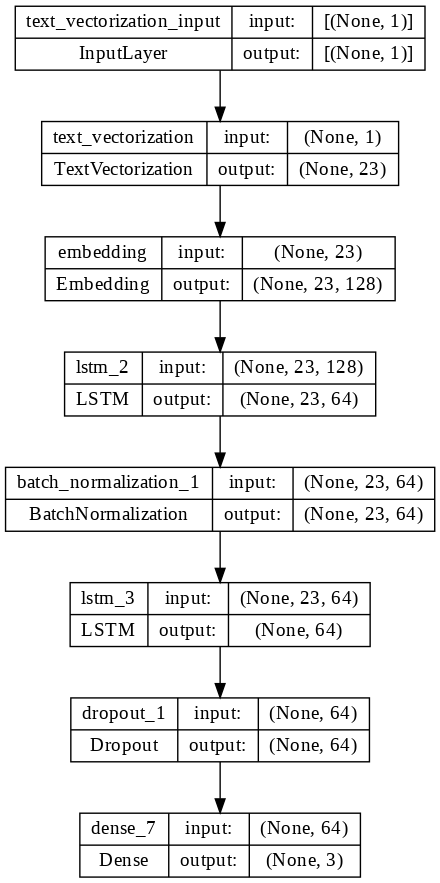

In [122]:
plot_model(model2_tn,'model2_tn.png',show_shapes=True,dpi=100)

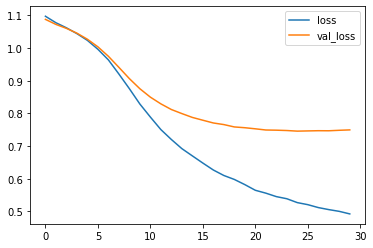

In [60]:
metrics = pd.DataFrame(model2_tun.history)
metrics[['loss', 'val_loss']].plot()

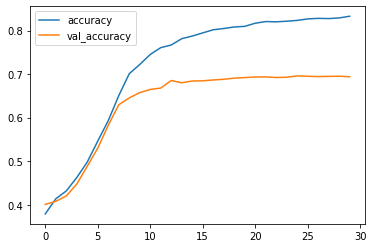

In [61]:
metrics = pd.DataFrame(model2_tun.history)
metrics[['accuracy', 'val_accuracy']].plot()

### GRU Tuning Model

In [62]:
#Model Tuning for GRU Model

model3_tn = Sequential()
model3_tn.add(text_vectorization)
model3_tn.add(embedding)
model3_tn.add(GRU(32, return_sequences=True))
model3_tn.add(tf.keras.layers.BatchNormalization())
model3_tn.add(GRU(32))
model3_tn.add(tf.keras.layers.Dropout(0.1))
model3_tn.add(Dense(3,activation='softmax'))

opt = keras.optimizers.RMSprop(learning_rate=0.0001)
model3_tn.compile(loss='categorical_crossentropy',optimizer= opt,metrics='accuracy')


In [63]:
#Training GRU Tuning Model

model3_tun = model3_tn.fit(x_train['text_processed'],
                         y_train_ohe,
                         epochs=30,
                         validation_data=(x_test['text_processed'], y_test_ohe))

Epoch 1/30
621/621 [==============================] - 10s 11ms/step - loss: 1.0369 - accuracy: 0.4495 - val_loss: 0.8797 - val_accuracy: 0.6244
Epoch 2/30
621/621 [==============================] - 6s 10ms/step - loss: 0.5725 - accuracy: 0.7884 - val_loss: 0.8328 - val_accuracy: 0.6832
Epoch 3/30
621/621 [==============================] - 6s 10ms/step - loss: 0.4237 - accuracy: 0.8480 - val_loss: 0.9378 - val_accuracy: 0.6440
Epoch 4/30
621/621 [==============================] - 6s 9ms/step - loss: 0.3516 - accuracy: 0.8801 - val_loss: 0.9852 - val_accuracy: 0.6505
Epoch 5/30
621/621 [==============================] - 6s 9ms/step - loss: 0.2936 - accuracy: 0.9046 - val_loss: 1.0815 - val_accuracy: 0.6360
Epoch 6/30
621/621 [==============================] - 6s 10ms/step - loss: 0.2447 - accuracy: 0.9231 - val_loss: 1.1247 - val_accuracy: 0.6392
Epoch 7/30
621/621 [==============================] - 6s 9ms/step - loss: 0.2213 - accuracy: 0.9302 - val_loss: 1.1905 - val_accuracy: 0.6357
E

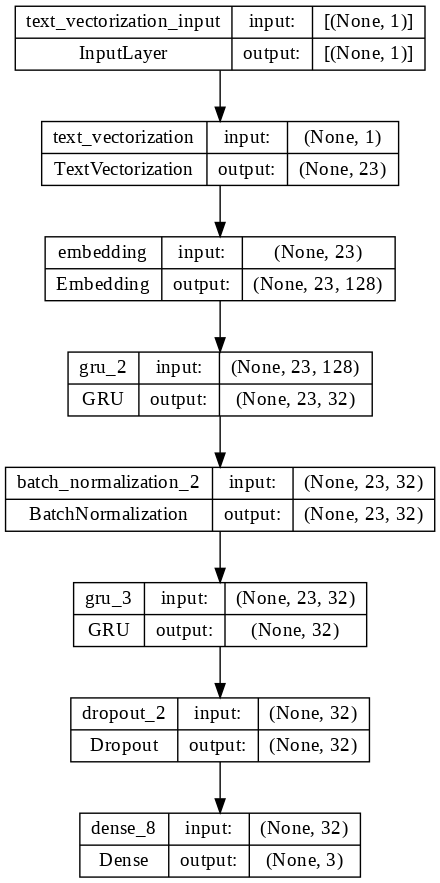

In [123]:
plot_model(model3_tn,'model3_tn.png',show_shapes=True,dpi=100)

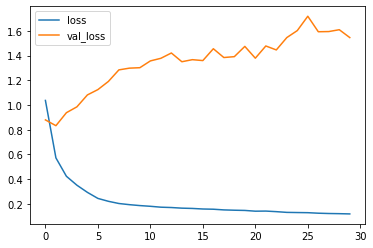

In [64]:
metrics = pd.DataFrame(model3_tun.history)
metrics[['loss', 'val_loss']].plot()

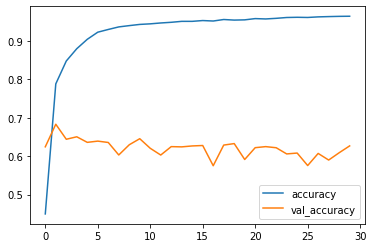

In [65]:
metrics = pd.DataFrame(model3_tun.history)
metrics[['accuracy', 'val_accuracy']].plot()

## viii. Model Evaluation

In [103]:
y_pred_test = y_test.astype(int).tolist()

In [110]:
pred = model_tn.predict(x_test['text_processed'])

194/194 [==============================] - 0s 2ms/step


In [74]:
y_pred = [np.argmax(i) for i in pred]

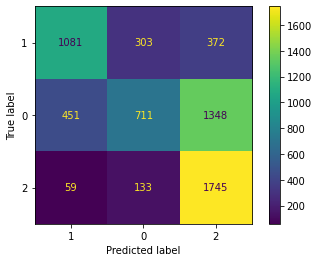

In [109]:
c = confusion_matrix(y_pred_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=df_cleaned["sentiment_score"].unique())
disp.plot()

Based on the confusion matrix above, it is seen that the prediction on true label 0 is abit too bad. which shown that the neutral sentiment oftenly predicted as positive. 

In [111]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1756
           1       0.62      0.28      0.39      2510
           2       0.50      0.90      0.65      1937

    accuracy                           0.57      6203
   macro avg       0.60      0.60      0.56      6203
weighted avg       0.60      0.57      0.54      6203



If we're focusing on the accuracy, it can be seen that the accuracy of the model is not good with 0.57 score. it means the dataset needs to be added more to give more information or even change the data.

## ix. Model Inference

In [96]:
dict1 = ['you are so stupid', 'you are so beautiful', 'i want to eat sandwich']
df_inf = pd.Series(dict1)

I made a new data above, to be used as a data inference. There are 3 sentences for data prediction as an inference.

In [99]:
inf_pred = model_tn.predict(df_inf)

1/1 [==============================] - 0s 16ms/step


In [100]:
inf_pred

array([[0.42323974, 0.3049041 , 0.27185616],
       [0.12109398, 0.21991447, 0.6589916 ],
       [0.26549125, 0.32730696, 0.40720177]], dtype=float32)

In [101]:
pred_inf = [np.argmax(i) for i in inf_pred]

In [102]:
pred_inf

[0, 2, 2]

It is seen that the first and the second sentiment are predicted right. Meanwhile, the third one supposed to be neutral, but the model predicted it as positive. which means the confusion matrix above is proven right that the sentiment neutral oftenly predicted as positive.

## x. Conclusion

From overall analysis that is just done, it can be concluded that:
- The model mostly overfit, it might be because of the data preprocessing that is not clean properly, or because the data is not that good as well.
- From 3 models used in the analysis, both base model and tuning model, it is found that the best model is GlobalAveragePooling after Tuning model. So, that model is choosen to be implemented on the data inference, and for predicting the sentiment prediction.
- From Exploratory Data Analysis (EDA), it is seen that the target data (sentiment) has imbalanced characteristic. which the most frequent one is neutral, and the least frequent is negative sentiment.
- Top 5 countries with the most frequent negative sentiment are 'Bhutan', 'Chad', 'Egypt', 'Azerbaijan', 'El Salvador'
- Top 5 countries with the most frequent neutral sentiment are 'Cambodia', 'Bosnia and Herzegovina', 'Chile', 'Mali', and 'France'
- Top 5 countries with the most frequent positive sentiment are 'Barbados', 'Argentina', 'Czechia', 'Netherlands', and 'Germany'
- Based on the data inference, after implemented the model, it can be seen that the confusion matrix is proven right with the fact that the third sentence supposed to be neutral but the model predicted it as positive.
- The classification report shows the accuracy score gotten is 0.57 which means the model is quiet bad, which needs to do more improvement.